In [35]:
import os
import sys
sys.path.append('..\\..\\')
import pickle
from user_fun.io import read_comsol

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from scipy.interpolate import griddata

xpinn_result_file = '..\\..\\para_result\\flow-base\\test_record.pkl'
with open(xpinn_result_file, 'rb') as file:
    loaded_test_record = pickle.load(file)

# 设置字体样式为 Times New Roman
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams.update({'font.size': 6})

import numpy as np
swapped_data_points = [record[0][:,[1,0]] for record in loaded_test_record]
field = [record[1][:,[0,2,1]] for record in loaded_test_record]


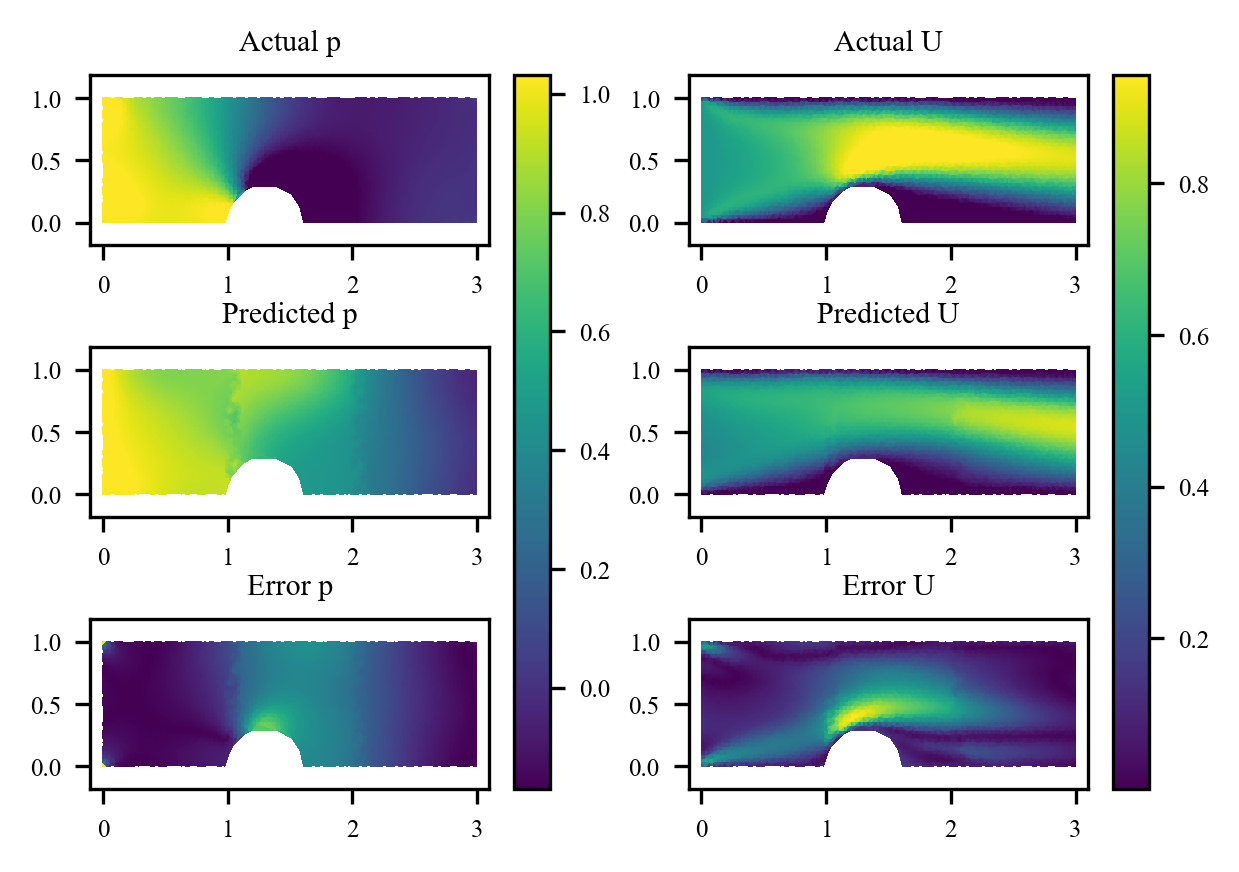

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

def mask_triangles(triang, x, y, radius=0.3, center=(1.3, 0)):
    tri_centroid_x = x[triang.triangles].mean(axis=1)
    tri_centroid_y = y[triang.triangles].mean(axis=1)
    mask = np.hypot(tri_centroid_x - center[0], tri_centroid_y - center[1]) < radius
    triang.set_mask(mask)
    return triang

def plot_actual_predicted_error(ax, data_points, actual_data, predicted_data, title, cmap='viridis', vmin=None, vmax=None):
    x = data_points[:, 0]
    y = data_points[:, 1]
    z = actual_data if predicted_data is None else predicted_data if actual_data is None else np.abs(predicted_data - actual_data)
    triang = tri.Triangulation(x, y)
    triang = mask_triangles(triang, x, y)
    im = ax.tripcolor(triang, z, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.axis('equal')
    return im

def plot_2d_flow_field(data_points, flow_data, save_file_name):
    # Read Comsol data file using the read_comsol.comsol_read function
    tb = read_comsol.comsol_read('half_cl.csv')
    tb_x = tb['% x'].to_numpy()
    tb_y = tb['y'].to_numpy()
    tb_p = tb['p (Pa)'].to_numpy()
    tb_u = tb['u (m/s)'].to_numpy()
    tb_v = tb['v (m/s)'].to_numpy()

    # Interpolate data to match lengths
    p_interp = griddata((tb_x, tb_y), tb_p, (data_points[:, 0], data_points[:, 1]), method='cubic')
    u_interp = griddata((tb_x, tb_y), tb_u, (data_points[:, 0], data_points[:, 1]), method='cubic')
    v_interp = griddata((tb_x, tb_y), tb_v, (data_points[:, 0], data_points[:, 1]), method='cubic')

    fig, axes = plt.subplots(3, 2, figsize=(4.72, 3.15),dpi = 300)
    
    # Calculate mean and variance for p and U
    p_mean = np.mean([p_interp, flow_data[:, 0]])
    p_var = np.var([p_interp, flow_data[:, 0]])
    U_mean = np.mean([np.sqrt(u_interp**2 + v_interp**2), np.sqrt(flow_data[:, 1]**2 + flow_data[:, 2]**2)])
    U_var = np.var([np.sqrt(u_interp**2 + v_interp**2), np.sqrt(flow_data[:, 1]**2 + flow_data[:, 2]**2)])

    vmin_p, vmax_p = p_mean - 3 * p_var, p_mean + 3 * p_var
    vmin_u, vmax_u = U_mean - 3 * U_var, U_mean + 3 * U_var

    im1 = plot_actual_predicted_error(axes[0, 0], data_points, p_interp, None, 'Actual p', vmin=vmin_p, vmax=vmax_p)
    im2 = plot_actual_predicted_error(axes[0, 1], data_points, np.sqrt(u_interp**2 + v_interp**2), None, 'Actual U', vmin=vmin_u, vmax=vmax_u)
    im3 = plot_actual_predicted_error(axes[1, 0], data_points, None, flow_data[:, 0], 'Predicted p', vmin=vmin_p, vmax=vmax_p)
    im4 = plot_actual_predicted_error(axes[1, 1], data_points, None, np.sqrt(flow_data[:, 1]**2 + flow_data[:, 2]**2), 'Predicted U', vmin=vmin_u, vmax = vmax_u)
    im5 = plot_actual_predicted_error(axes[2, 0], data_points, p_interp, flow_data[:, 0], 'Error p')
    im6 = plot_actual_predicted_error(axes[2, 1], data_points, np.sqrt(u_interp**2 + v_interp**2), np.sqrt(flow_data[:, 1]**2 + flow_data[:, 2]**2), 'Error U')

    for ax in axes.ravel():
        ax.set_xlim(-0.1, 3.1)
        ax.set_ylim(-0.1, 1.1)

    fig.subplots_adjust(wspace=0.2,hspace=0.6)

    # Add colorbar to the figure
    fig.colorbar(im3, ax=axes[:, 0].ravel().tolist())
    fig.colorbar(im6, ax=axes[:, 1].ravel().tolist())

    fig.savefig(save_file_name, dpi=300, facecolor='white')

    plt.show()



def calculate_error(plot_input, plot_output):
    # Read Comsol data file
    tb = read_comsol.comsol_read('half_cl.csv')
    x = tb['% x'].to_numpy()
    y = tb['y'].to_numpy()
    p = tb['p (Pa)'].to_numpy()
    u = tb['u (m/s)'].to_numpy()
    v = tb['v (m/s)'].to_numpy()

    # Interpolate data on the same grid as tb data
    p_pred_interp = griddata((plot_input[:, 0], plot_input[:, 1]), plot_output[:, 0], (x, y), method='cubic')
    u_pred_interp = griddata((plot_input[:, 0], plot_input[:, 1]), plot_output[:, 1], (x, y), method='cubic')
    v_pred_interp = griddata((plot_input[:, 0], plot_input[:, 1]), plot_output[:, 2], (x, y), method='cubic')

    # Calculate relative error
    p_relative_error = np.abs((p - p_pred_interp))

    u_error =  np.sqrt((u - u_pred_interp)**2 + (v - v_pred_interp)**2)


    # Calculate mean and maximum relative error
    mean_p_relative_error = np.nanmean(p_relative_error)
    max_p_relative_error = np.nanmax(p_relative_error)
    
    mean_u_error = np.nanmean(u_error)
    max_u_error = np.nanmax(u_error)

    return (mean_p_relative_error, max_p_relative_error), \
        (mean_u_error, max_u_error)



plot_2d_flow_field(swapped_data_points[999], field[999],'flow-1.png')


In [37]:
xpinn_error = []
for i in range(0,1000,10):
    xpinn_error.append(calculate_error(swapped_data_points[i], field[i]))

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from scipy.interpolate import griddata


(3098, 2)


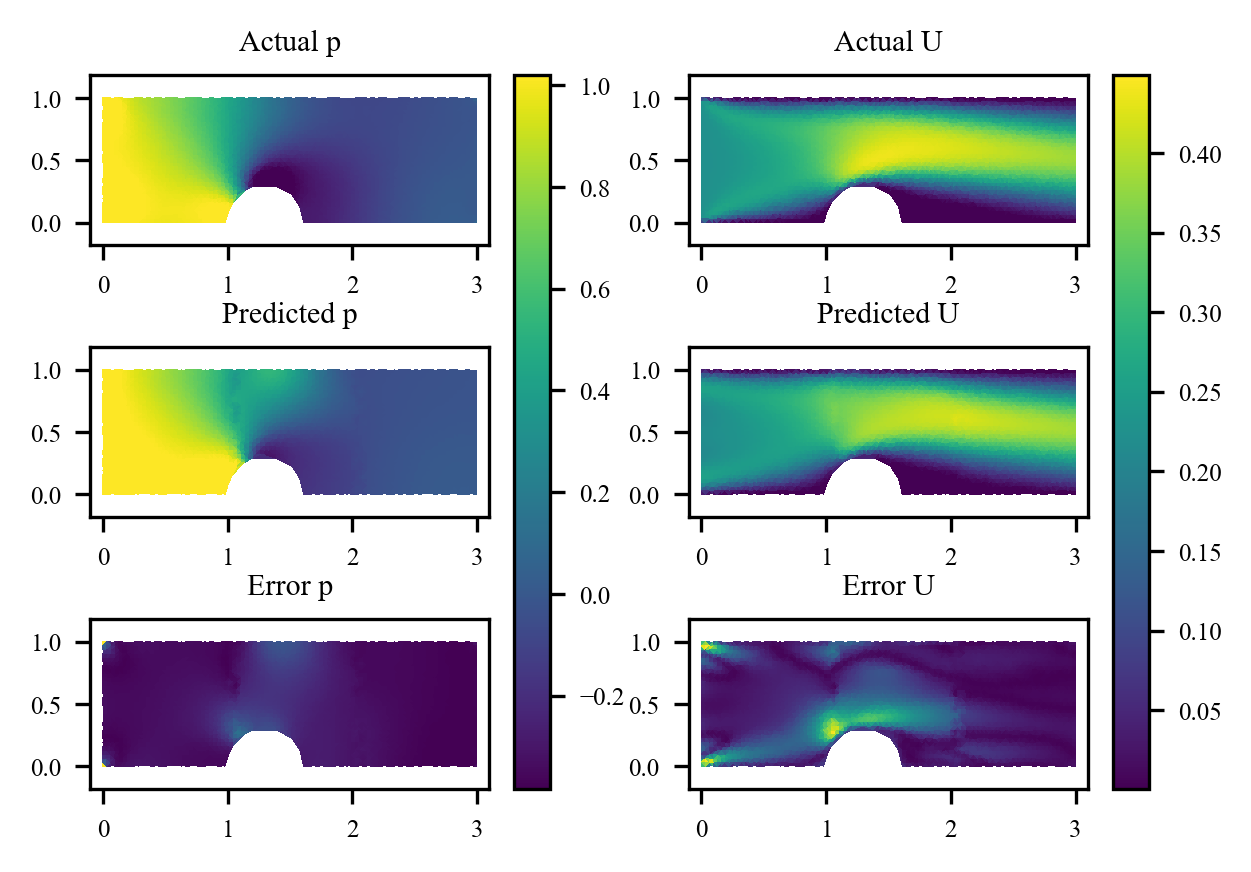

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from scipy.interpolate import griddata

file = '..\\..\\para_result\\flow-step1\\test_record.pkl'

with open(file, 'rb') as file:
    loaded_test_record = pickle.load(file)

import numpy as np
swapped_data_points = [np.array([record[0][:, 1], record[0][:, 0]]).T for record in loaded_test_record]
print(swapped_data_points[0].shape)  # (3098, 2)

field = [record[1][:,[0,2,1]] for record in loaded_test_record]

udpinn_error = [] 
for i in range(0,1000,10):
    udpinn_error.append(calculate_error(swapped_data_points[i], field[i]))

plot_2d_flow_field(swapped_data_points[999], field[999],'flow-2.png')


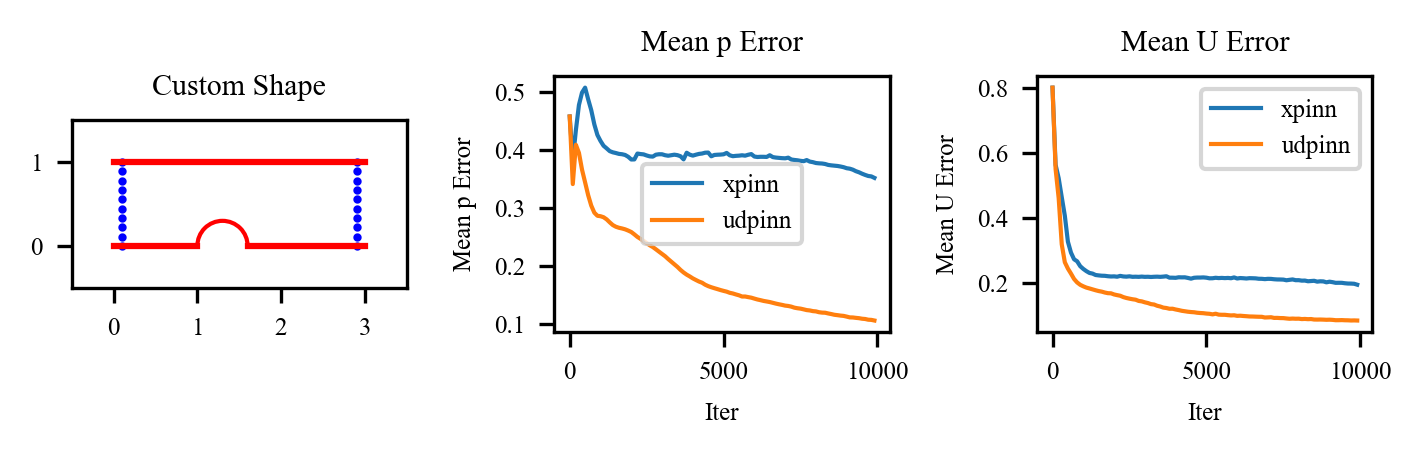

In [39]:
import matplotlib.pyplot as plt
from matplotlib.patches import Arc

# 创建x轴数据
x_data = np.array(list(range(0, 1000, 10)))*10

# 提取误差数据
xpinn_p_mean_errors = [error[0][0] for error in xpinn_error]
udpinn_p_mean_errors = [error[0][0] for error in udpinn_error]

xpinn_u_mean_errors = [error[1][0] for error in xpinn_error]
udpinn_u_mean_errors = [error[1][0] for error in udpinn_error]

# 创建子图
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(4.72, 1.5),dpi = 300)


# 子图1：绘制两条线
# Line 1: (0,1) to (3,1)
ax1.plot([0, 3], [1, 1], 'r')

# Line 2: (0,0) to (1,0) -> half-circle arc -> (1.6,0) to (3,0)
ax1.plot([0, 1], [0, 0], 'r')
ax1.add_patch(Arc((1.3, 0), 0.6, 0.6, theta1=0, theta2=180, color='r'))
ax1.plot([1.6, 3], [0, 0], 'r')

# Add random points
#np.random.seed(1)  # For reproducibility
y_rand_01 = np.linspace(0, 1, 10)
y_rand_29 = np.linspace(0, 1, 10)

ax1.scatter([0.1] * 10, y_rand_01, c='b',s = 1)
ax1.scatter([2.9] * 10, y_rand_29, c='b',s = 1)

ax1.set_xlim(-0.5, 3.5)
ax1.set_ylim(-0.5, 1.5)
ax1.set_aspect('equal', adjustable='box')
ax1.set_title('Custom Shape')

# 子图1：p均值误差
ax2.plot(x_data, xpinn_p_mean_errors, label='xpinn', linewidth=1)
ax2.plot(x_data, udpinn_p_mean_errors, label='udpinn', linewidth=1)
ax2.set_title('Mean p Error')
ax2.set_xlabel('Iter')
ax2.set_ylabel('Mean p Error')
ax2.legend()

# 子图2：U均值误差
ax3.plot(x_data, xpinn_u_mean_errors, label='xpinn', linewidth=1)
ax3.plot(x_data, udpinn_u_mean_errors, label='udpinn', linewidth=1)
ax3.set_title('Mean U Error')
ax3.set_xlabel('Iter')
ax3.set_ylabel('Mean U Error')
ax3.legend()

# 显示图像
plt.tight_layout()
fig.savefig('flow-3.png', dpi=300, facecolor='white')
plt.show()
